# Use trained MaxEnt model with BGC Argo data to predict species composition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean
import seaborn as sns
import xarray as xr
import pyproj
import matplotlib.path as mpath
import os
import re

from tqdm.notebook import tqdm
from osgeo import gdal

In [2]:
def so_ax():
  """
  Create a map of the Southern Ocean.
  """
  map_proj = ccrs.SouthPolarStereo()
  fig = plt.figure(figsize=[12, 12])  # inches
  ax = plt.subplot(projection=map_proj)
  ax.set_extent([-180, 180, -90, -29.4], ccrs.PlateCarree())
  ax.gridlines(linestyle='--', draw_labels=True)
  ax.add_feature(cartopy.feature.LAND, zorder=2)
  return fig, ax

# Make SO plot boundary a circle
def plot_circle_boundary(ax):
    """
    Make SO plot boundary a circle.
    Compute a circle in axes coordinates, which we can use as a boundary for the map.
    We can pan/zoom as much as we like - the boundary will be permanently circular.
    """
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  # could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

In [3]:
bgc = xr.open_dataset(r"C:\Users\Ayush Nag\Downloads\SOCCOM_LoResQC_LIAR_19May2022_combined_SO_20to1000m_20m_intervals_T_S_O_N_chl_bbp.nc")
# bgc = bgc.where(bgc['month'].isin([12, 1, 2]), drop=True)
# bgc.sel(x=slice(-180, 180), y=slice(-90, -40)).plot.scatter(x='x', y='y', hue='month', col='variable', col_wrap=3)

# ax = so_ax()
# bgc['temperature'][0].plot.pcolormesh(x="longitude", y="latitude", transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal)

In [4]:
bgc

<xarray.Dataset>
Dimensions:      (profile: 5785, pressure: 50)
Coordinates:
  * pressure     (pressure) int64 20 40 60 80 100 120 ... 920 940 960 980 1000
    floatnum     (profile) object ...
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    datetime     (profile) datetime64[ns] ...
    year         (profile) int64 ...
    month        (profile) int64 ...
    day          (profile) int64 ...
Dimensions without coordinates: profile
Data variables:
    temperature  (profile, pressure) float64 ...
    salinity     (profile, pressure) float64 ...
    oxygen       (profile, pressure) float64 ...
    nitrate      (profile, pressure) float64 ...
    chl          (profile, pressure) float64 ...
    b_bp700      (profile, pressure) float64 ...

AttributeError: 'tuple' object has no attribute 'scatter'

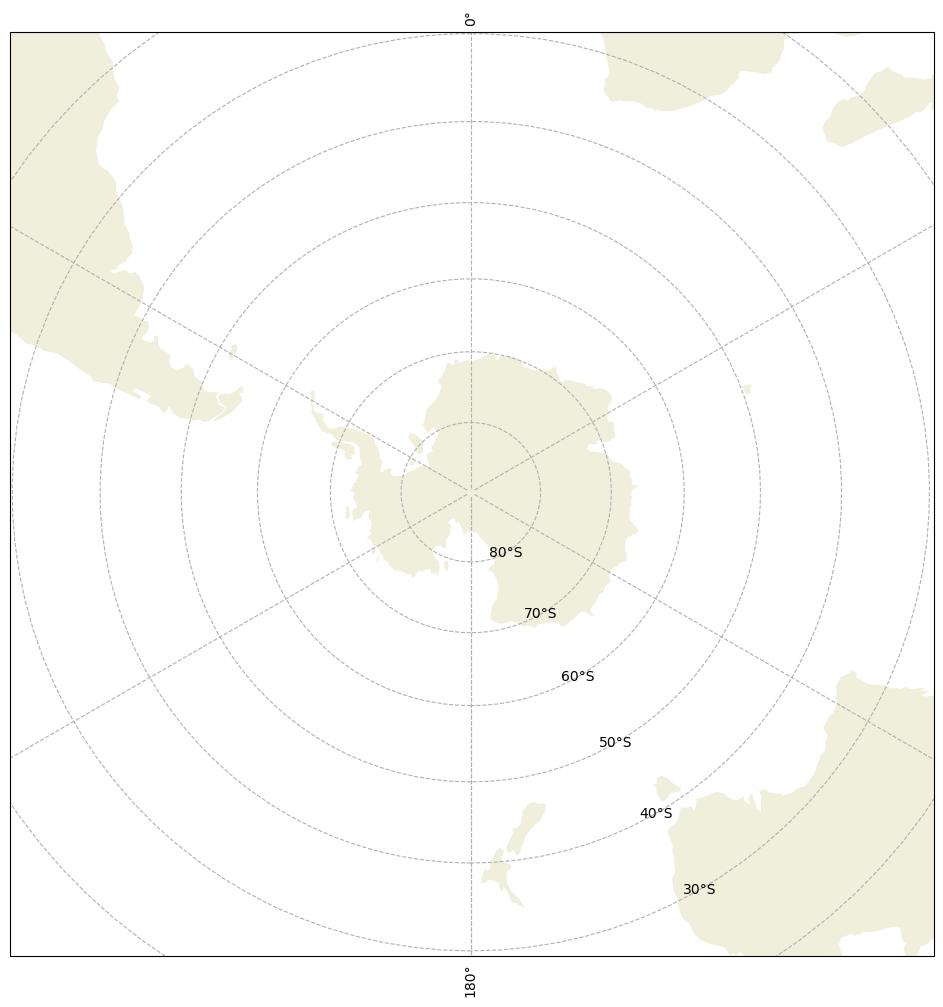

In [5]:
float_dataset = bgc.where(bgc.floatnum == '5904856QC', drop=True)
    
float_dataset = float_dataset[['datetime', 'year', 'month', 'latitude', 'longitude', 'profile', 'pressure', 'chl']]
float_dataset_pressure_level = float_dataset.where(float_dataset.pressure == 40, drop=True)
# float_dataset_pressure_level.longitude.values
ax = so_ax()
ax.scatter(float_dataset_pressure_level.longitude - 180, float_dataset_pressure_level.latitude, c=float_dataset_pressure_level.chl, cmap=cmocean.cm.algae, transform=ccrs.PlateCarree())

In [6]:
# TODO: Compare .lambdas min/max output with 'real' min/max from dataset (B-SOSE)
def parse_lambdas(lambdas_file: str) -> tuple[pd.DataFrame, dict]:
  # open file and read lines
  with open(lambdas_file, 'r') as file:
    lambdas: list = file.readlines()

  parsed: list = []
  meta: dict = {}
  prefix_to_type: dict = {'==': 'categorical', '<=': 'threshold', '^': 'quadratic', '*': 'product', '`': 'reverse_hinge', "'": 'forward_hinge'}
  for line in lambdas:
    # split the line into parts
    parts: list = re.split(', ', line)
    # if there are 4 parts, it's a feature line
    if len(parts) == 4:
      feature, _lambda, vmin, vmax = parts
      feature: str = feature.replace('=', '==').replace('<', '<=')
      # extract the prefix from the feature
      prefix: str = re.sub("\\w|\\.|-|\\(|\\)", "", feature)
      # replace prefix with feature type (no prefix means its linear)
      typ: str = prefix_to_type[prefix] if prefix in prefix_to_type else 'linear'
      # remove the prefix from the feature
      feature: str = re.sub('\\^2|\\(.*?<=|\\((.*?)==.*?|`|\\\'|\\)', "\\1", feature)
      parsed.append([feature, typ, float(_lambda), float(vmin), float(vmax)])
    elif len(parts) == 2:
      # if there are 2 parts, it's a metadata line
      key, value = parts
      meta[key] = float(value)

  parsed_df = pd.DataFrame(parsed, columns=['feature', 'type', 'lambda', 'min', 'max'])
  parsed_df['type'] = pd.Categorical(parsed_df['type'])
  # return the parsed dataframe and the metadata
  return parsed_df, meta

In [7]:
a = parse_lambdas("../../data/maxent/out/java/summer/Bacillariophyceae.lambdas")[0]
# a = a[a['lambda'] != 0]
# a['feature'].unique()
a

feature           type    lambda        min        max
0       chlorophyll_summer         linear  0.000000   0.030569   0.814084
1           nitrate_summer         linear  0.407591   0.000241   0.030521
2            oxygen_summer         linear  0.000000   0.196474   0.374715
3          salinity_summer         linear  0.000000  31.778599  36.715591
4    sea_ice_extent_summer         linear -0.059211   0.000000   0.984788
..                     ...            ...       ...        ...        ...
130          oxygen_summer  reverse_hinge  0.031292   0.196474   0.305937
131         nitrate_summer  forward_hinge -0.045580   0.026341   0.030521
132     chlorophyll_summer  reverse_hinge  0.058130   0.030569   0.213272
133         nitrate_summer  reverse_hinge  0.029432   0.000241   0.002986
134     chlorophyll_summer  reverse_hinge -0.030046   0.030569   0.276675

[135 rows x 5 columns]

In [8]:
asc_dir = "../../data/maxent/in/bsose_processed/asc/summer/"
data_df = pd.DataFrame()
for file in os.listdir(asc_dir):
  if file.endswith(".asc"):
    ds = gdal.Open(asc_dir + file)
    data = ds.ReadAsArray()
    data = np.flipud(data)
    # Split the array into left and right halves
    left, right = np.hsplit(data, 2)
    # Swap the left and right halves
    data = np.hstack((right, left))
    data = data.flatten()
    data = np.ma.masked_where(data == -9999, data)
    data_df[file.rstrip(".asc")] = data
data_df

# ds = gdal.Open("../../data/maxent/in/bsose_processed/asc/summer/chlorophyll_summer.asc")
# distribution_grid = ds.ReadAsArray()
# distribution_grid.flatten()

chlorophyll_summer  nitrate_summer  oxygen_summer  salinity_summer  \
0                       NaN             NaN            NaN              NaN   
1                       NaN             NaN            NaN              NaN   
2                       NaN             NaN            NaN              NaN   
3                       NaN             NaN            NaN              NaN   
4                       NaN             NaN            NaN              NaN   
...                     ...             ...            ...              ...   
1270075            0.120323        0.000948       0.238027        35.963554   
1270076            0.121934        0.000959       0.238134        35.957230   
1270077            0.123689        0.000975       0.238269        35.949482   
1270078            0.125692        0.001002       0.238458        35.939903   
1270079            0.127736        0.001030       0.238647        35.931026   

         sea_ice_extent_summer  temperature_summer  
0                          0.0            0.000000  
1                          0.0            0.000000  
2                          0.0            0.000000  
3                          0.0            0.000000  
4                          0.0            0.000000  
...                        ...                 ...  
1270075                    0.0           20.460915  
1270076                    0.0           20.436157  
1270077                    0.0           20.412092  
1270078                    0.0           20.375330  
1270079                    0.0           20.337896  

[1270080 rows x 6 columns]

In [152]:
len(data_df['chlorophyll_summer'].unique())

889453

In [20]:
# TODO: add print statements for all the terms "lambda * chla^2 ..."
# TODO: calculate pred - original; if (+) then term may be missing

def maxent_predict(lambdas: str, data: pd.DataFrame) -> pd.DataFrame:
  # parse the lambdas file
  lambdas_df, meta = parse_lambdas(lambdas)
  # drop rows with lambda = 0
  lambdas_df = lambdas_df[lambdas_df['lambda'] != 0]
  # get the features from the data
  linearPredictorNormalizer, densityNormalizer, entropy = meta['linearPredictorNormalizer'], meta['densityNormalizer'], meta['entropy']
  predictions = np.zeros(len(data))
  types = []
  for lambda_index, lambda_row in tqdm(lambdas_df.iterrows()):
    feature, typ, _lambda, vmin, vmax = lambda_row
    match typ:
      case 'linear':
        x: pd.Series = data[feature]
        predictions += _lambda * (x - vmin) / (vmax - vmin)
      case 'quadratic':
        x: pd.Series = data[feature]
        predictions += _lambda * (x*x - vmin) / (vmax - vmin)
      case 'product':
        f1, f2 = feature.split('*')
        x1, x2 = data[f1], data[f2]
        predictions += _lambda * (x1*x2 - vmin) / (vmax - vmin)
      case 'forward_hinge':
        x: pd.Series = data[feature]
        # here min = hinge
        # predictions += 0 if x < min else _lambda * (x - min) / (max - min)
        predictions += np.where(x < vmin, 0, _lambda * (x - vmin) / (vmax - vmin))
      case 'reverse_hinge':
        x: pd.Series = data[feature]
        # here max = hinge
        # predictions +=  _lambda * (max - x) / (max - min) if x < max else 0
        predictions += np.where(x < vmax, _lambda * (vmax - x) / (vmax - vmin), 0)
      case 'threshold':
        x: pd.Series = data[feature]
        # value to the left of the '<' is the hinge
        thresh = feature.split('<')[0]
        # predictions += 0 if x < thresh else _lambda
        predictions += np.where(x < thresh, 0, _lambda)
    types.append(typ)
  print(np.unique(np.asarray(types), return_counts=True))
  predictions -= linearPredictorNormalizer
  qx = np.exp(predictions) / densityNormalizer
  # logistic scale the prediction to [0, 1]
  qx = (qx * np.exp(entropy)) / (1 + qx * np.exp(entropy))
  predictions = qx
  return predictions

In [21]:
pred = maxent_predict("../../data/maxent/out/java/summer/Bacillariophyceae.lambdas", data_df)

0it [00:00, ?it/s]

(array(['forward_hinge', 'linear', 'product', 'quadratic', 'reverse_hinge'],
      dtype='<U13'), array([53,  2,  6,  1, 69], dtype=int64))


In [11]:
ds = gdal.Open("../../data/maxent/out/java/summer/Bacillariophyceae.asc")
distribution_grid = ds.ReadAsArray()
distribution_grid = np.flipud(distribution_grid)
# Split the array into left and right halves
left, right = np.hsplit(distribution_grid, 2)
# Swap the left and right halves
distribution_grid = np.hstack((right, left))
# Mask the NODATA values
# distribution_grid = np.ma.masked_where(distribution_grid == -9999, distribution_grid)
distribution_grid

array([[-9.99900e+03, -9.99900e+03, -9.99900e+03, ..., -9.99900e+03,
        -9.99900e+03, -9.99900e+03],
       [-9.99900e+03, -9.99900e+03, -9.99900e+03, ..., -9.99900e+03,
        -9.99900e+03, -9.99900e+03],
       [-9.99900e+03, -9.99900e+03, -9.99900e+03, ..., -9.99900e+03,
        -9.99900e+03, -9.99900e+03],
       ...,
       [ 2.78040e-02,  3.07829e-02,  3.37521e-02, ...,  1.95820e-02,
         2.22769e-02,  2.50187e-02],
       [ 2.59307e-02,  2.85905e-02,  3.14920e-02, ...,  1.83842e-02,
         2.07277e-02,  2.33717e-02],
       [ 2.39668e-02,  2.58689e-02,  2.77708e-02, ...,  1.70891e-02,
         1.93393e-02,  2.18277e-02]], dtype=float32)

In [169]:
c = pred.to_numpy()
c[np.isnan(c)] = -9999
np.count_nonzero(c == distribution_grid.flatten())

328809

In [12]:
#### FONT SIZES
fontsize_large  = 10
fontsize_medium = 8
fontsize_small  = 6
#### MARKER SIZES
markersize  = 0.75
#### TICK SIZES
tick_length = 5
tick_width  = 2

#### PLOT COLORS
overplot_label_color    = '#7B878F'  # '#EFF3FC'  # very light blue-grey
darker_label_color      = '#C9CCD4'  # darker version of above
background_poster_color = '#14417C'

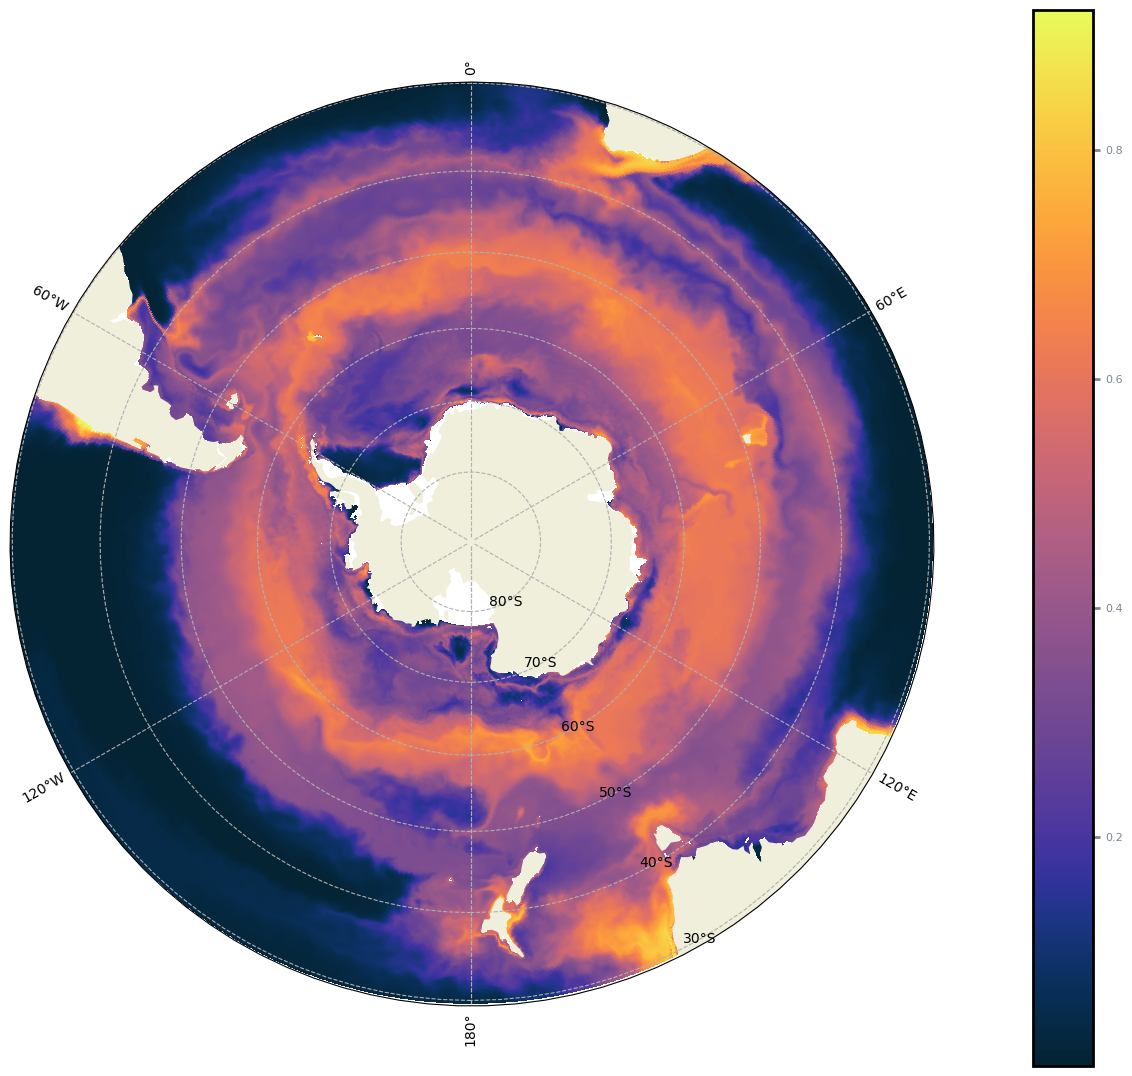

In [13]:
fig, ax = so_ax()
ax = plot_circle_boundary(ax)

bsose_processed_nc_dir = '../../data/maxent/in/bsose_processed/netcdf'
sal = xr.open_dataset(f'{bsose_processed_nc_dir}/salinity_summer.nc')
x, y = sal.XC.to_numpy(), sal.YC.to_numpy()
mx, my = np.meshgrid(x, y)
proj = pyproj.Transformer.from_crs(4326, 3395, always_xy=True)
mx, my = proj.transform(mx, my)
# mask nan
p = pred.to_numpy().reshape((len(y), len(x)))
maxent_ax = ax.pcolormesh(mx, my, p, transform=ccrs.Mercator(), cmap=cmocean.cm.thermal)

cbar = plt.colorbar(maxent_ax, ax=ax, ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], cax = fig.add_axes([0.98, 0.06, 0.05, 0.88]))
cbar.ax.tick_params(labelsize=fontsize_medium, color=overplot_label_color, labelcolor=overplot_label_color)
cbar.outline.set_linewidth(2)
# cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.tick_params(labelsize=fontsize_medium, color=overplot_label_color, labelcolor=overplot_label_color, width=tick_width, length=tick_length)

In [181]:
# Create base grid in Mercator projection for environmental layers
# Picked random envinronmental layer to get the grid from
sal = xr.open_dataset(f'{bsose_processed_nc_dir}/salinity_summer.nc')
x, y = sal.XC.to_numpy(), sal.YC.to_numpy()
mx, my = np.meshgrid(x, y)
proj = pyproj.Transformer.from_crs(4326, 3395, always_xy=True)
mx, my = proj.transform(mx, my)

def plot_maxent_asc(filename: str, ax: plt.Axes) -> plt.Axes:
  ds = gdal.Open(filename)
  distribution_grid = ds.ReadAsArray()
  distribution_grid = np.flipud(distribution_grid)
  # Split the array into left and right halves
  left, right = np.hsplit(distribution_grid, 2)
  # Swap the left and right halves
  distribution_grid = np.hstack((right, left))
  # Mask the NODATA values
  distribution_grid = np.ma.masked_where(distribution_grid == -9999, distribution_grid)
  ax.pcolormesh(mx, my, distribution_grid, transform=ccrs.Mercator(), cmap=cmocean.cm.thermal)
  return ax

In [185]:
np.nanmax(pred.to_numpy())

0.9224335884474452

In [186]:
np.nanmax(distribution_grid)

0.999987

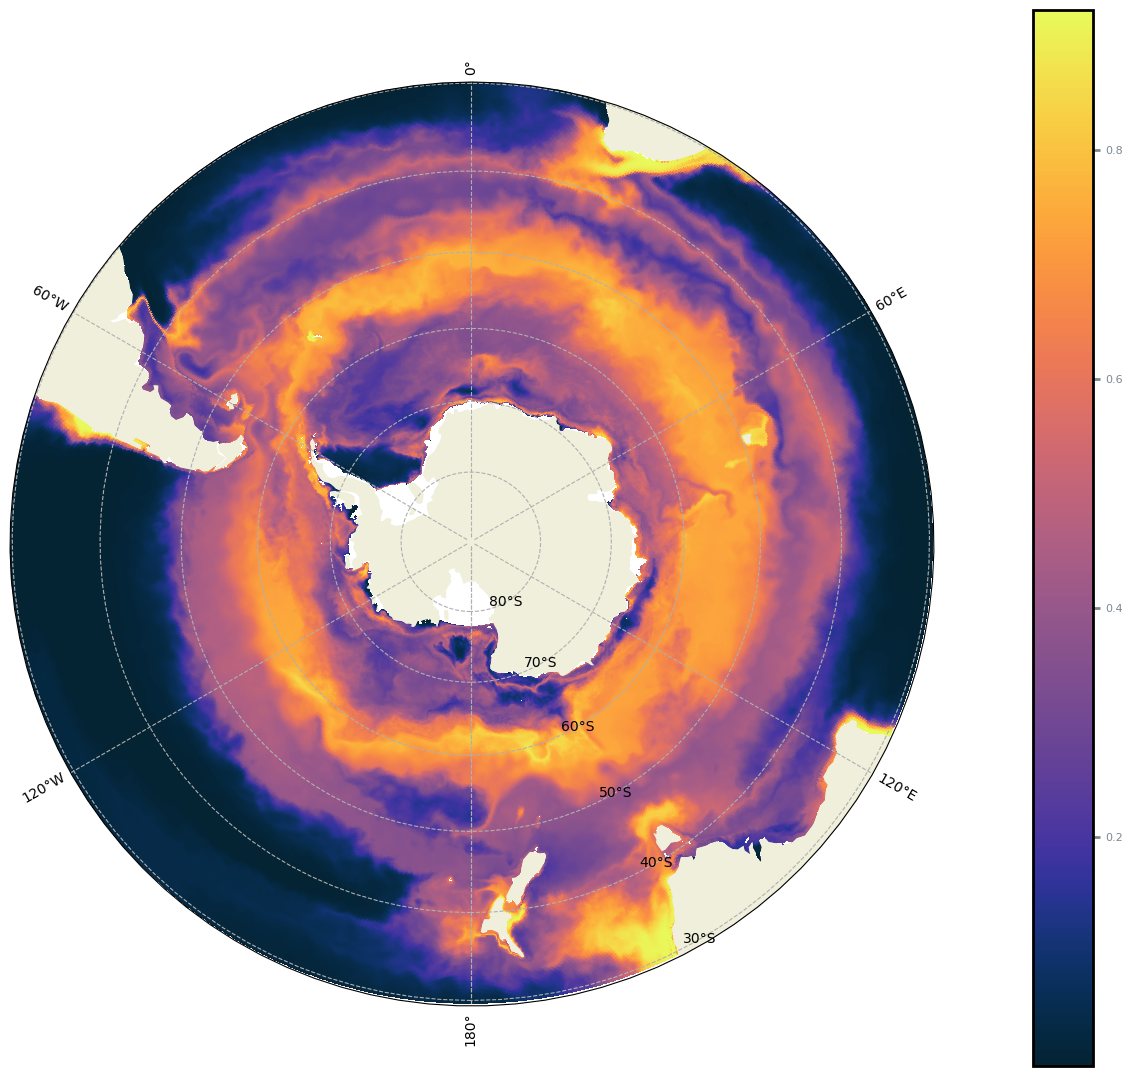

In [187]:
fig, ax = so_ax()
ax = plot_circle_boundary(ax)
ax = plot_maxent_asc('../../data/maxent/out/java/summer/Bacillariophyceae.asc', ax)
# zones = gpd.read_file(fronts_shapefile)
# zones.plot(ax=ax, color='none', edgecolor='white', linewidth=1, transform=ccrs.SouthPolarStereo())
ax.add_feature(cartopy.feature.LAND, zorder=2)

cbar = plt.colorbar(maxent_ax, ax=ax, cax = fig.add_axes([0.98, 0.06, 0.05, 0.88]))
cbar.ax.tick_params(labelsize=fontsize_medium, color=overplot_label_color, labelcolor=overplot_label_color)
cbar.outline.set_linewidth(2)
# cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.tick_params(labelsize=fontsize_medium, color=overplot_label_color, labelcolor=overplot_label_color, width=tick_width, length=tick_length)

Processing environmental variables:   0%|          | 0/6 [00:00<?, ?it/s]

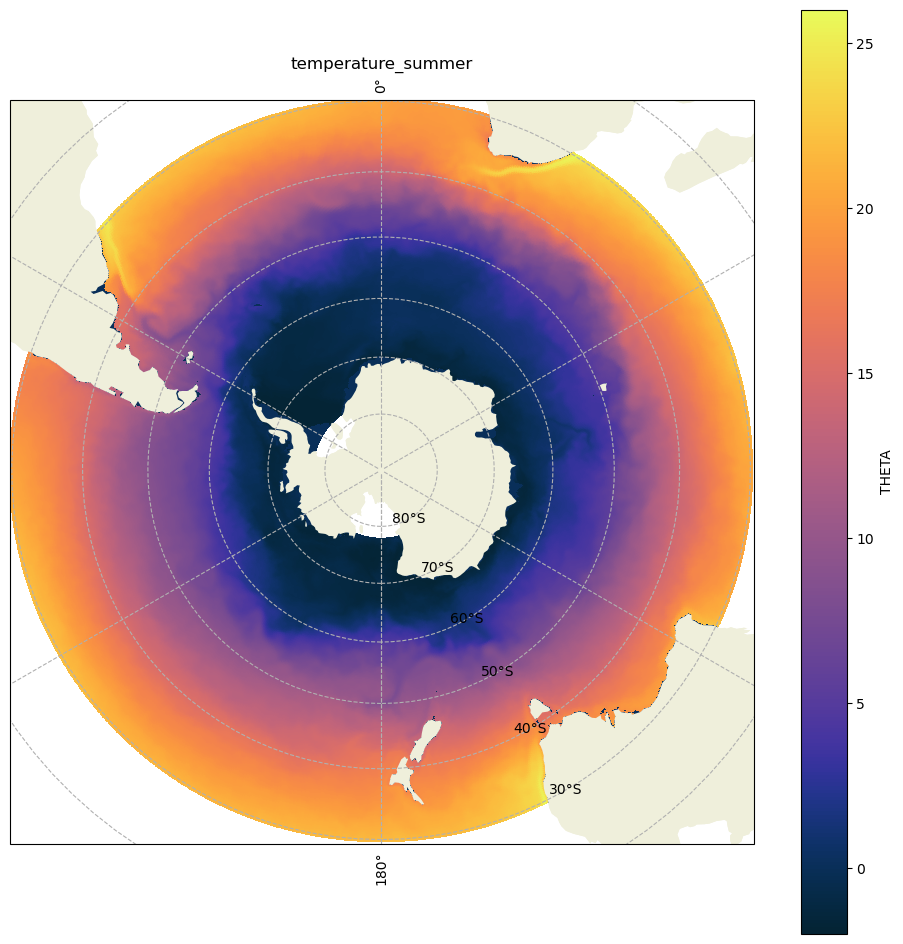

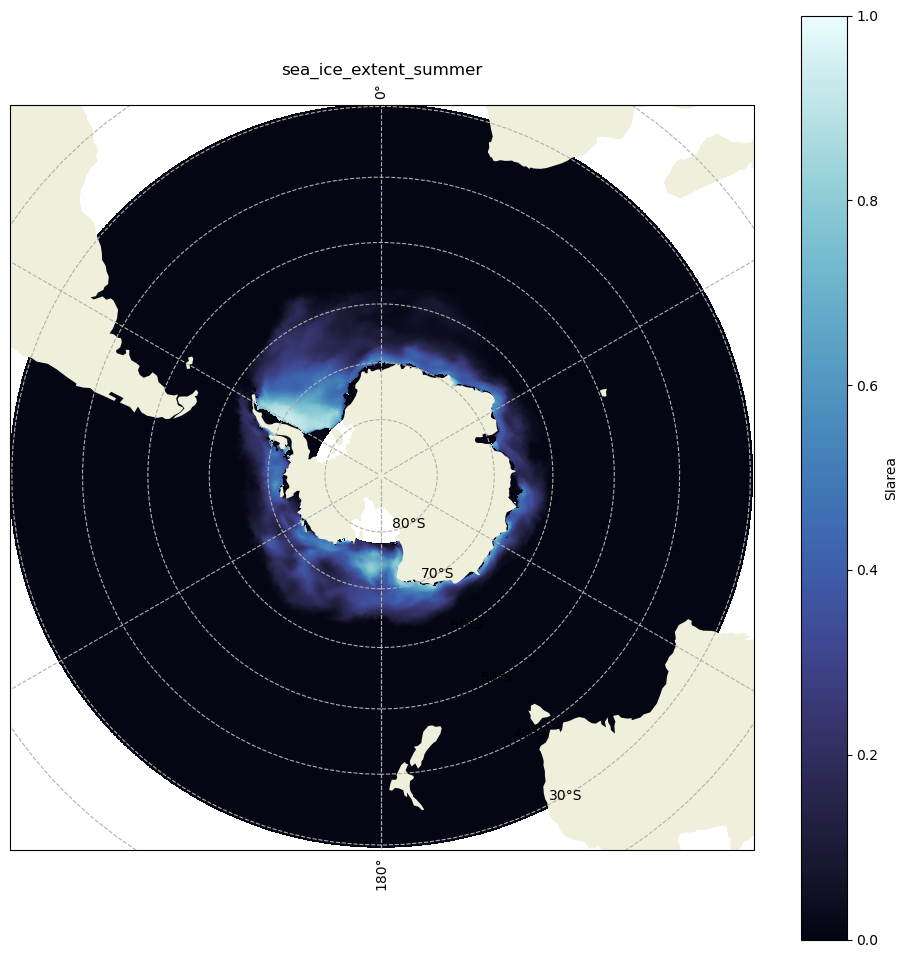

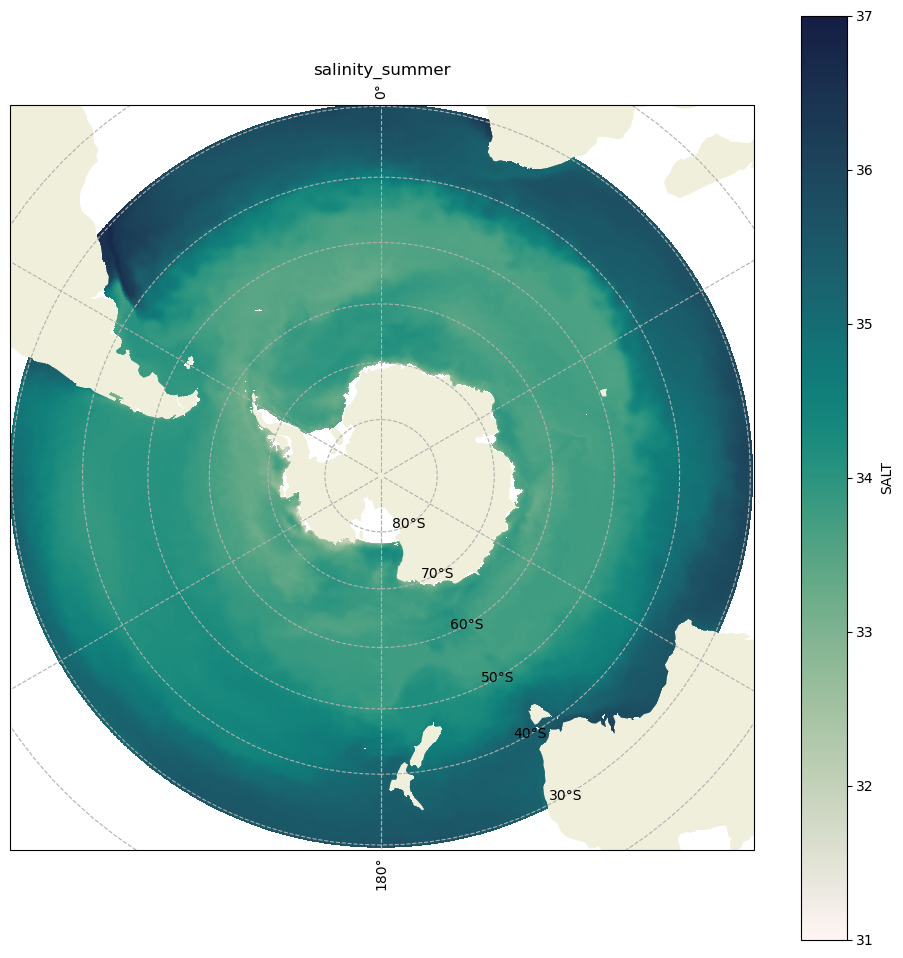

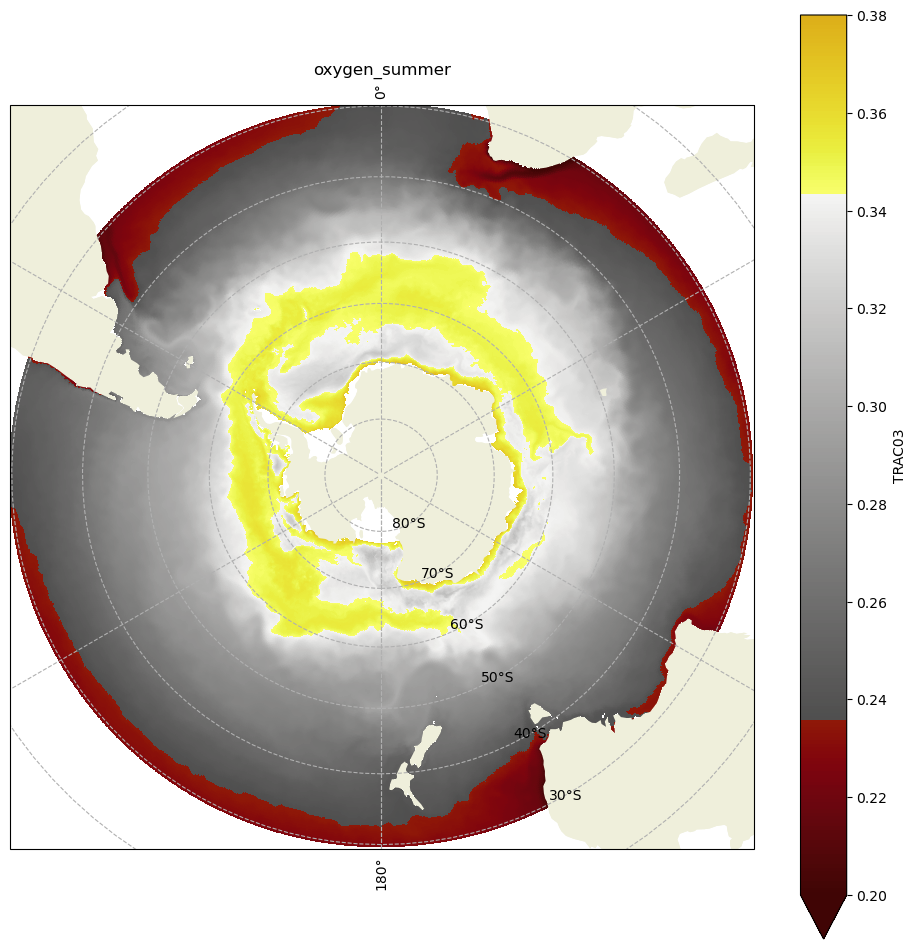

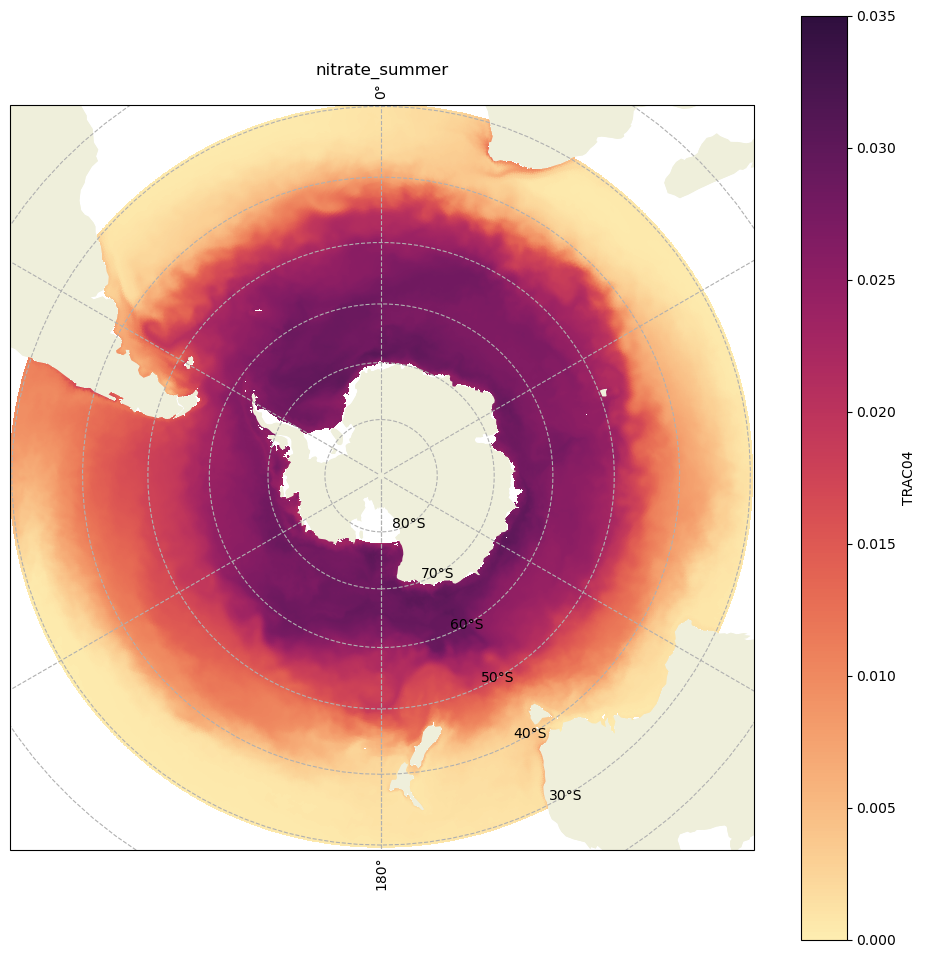

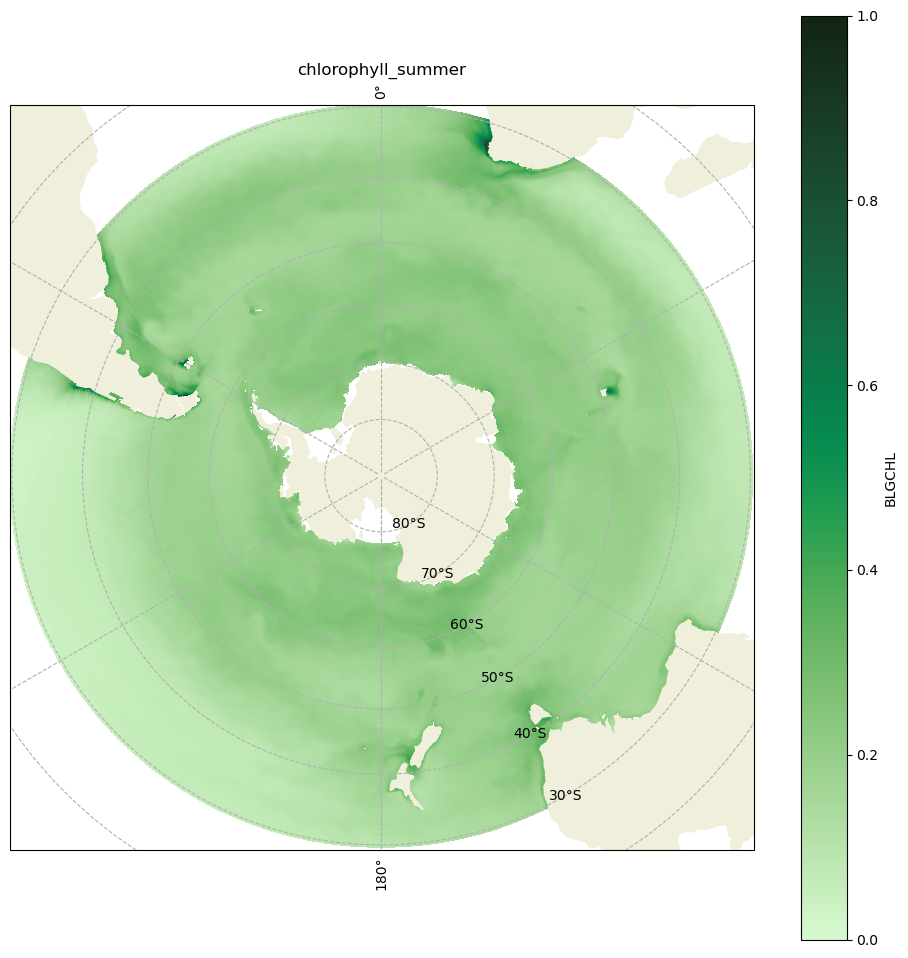

In [195]:
def so_ax():
  """
  Create a map of the Southern Ocean.
  """
  map_proj = ccrs.SouthPolarStereo()
  fig = plt.figure(figsize=[12, 12])  # inches
  ax = plt.subplot(projection=map_proj)
  ax.set_extent([-180, 180, -90, -29.4], ccrs.PlateCarree())
  ax.gridlines(linestyle='--', draw_labels=True)
  ax.add_feature(cartopy.feature.LAND)
  return ax

# Make SO plot boundary a circle
def plot_circle_boundary(ax):
    """
    Make SO plot boundary a circle.
    Compute a circle in axes coordinates, which we can use as a boundary for the map.
    We can pan/zoom as much as we like - the boundary will be permanently circular.
    """
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  # could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

bsose_processed_nc_dir = '../../data/maxent/in/bsose_processed/netcdf'
seasons = ['summer', 'autumn', 'winter', 'spring']
var_info = {'THETA': {'cmap': cmocean.cm.thermal, 'simple_name': 'temperature', 'file_prefix': 'Theta', 'vmin': -2, 'vmax': 26},
            'SIarea': {'cmap': cmocean.cm.ice, 'simple_name': 'sea_ice_extent', 'file_prefix': 'SeaIceArea', 'vmin': 0, 'vmax': 1},
            'SALT': {'cmap': cmocean.cm.tempo, 'simple_name': 'salinity', 'file_prefix': 'Salt', 'vmin': 31, 'vmax': 37},
            'TRAC03': {'cmap': cmocean.cm.oxy, 'simple_name': 'oxygen', 'file_prefix': 'O2', 'vmin': 0.2, 'vmax': 0.38},
            'TRAC04': {'cmap': cmocean.cm.matter, 'simple_name': 'nitrate', 'file_prefix': 'NO3', 'vmin': 0, 'vmax': 0.035},
            'BLGCHL': {'cmap': cmocean.cm.algae, 'simple_name': 'chlorophyll', 'file_prefix': 'Chl', 'vmin': 0, 'vmax': 1}}

for var in tqdm(var_info.keys(), desc='Processing environmental variables'):
  ax = so_ax()
  # fig, ax = plot_circle_boundary(ax)
  ax.set_extent([-180, 180, -90, -29.4], ccrs.PlateCarree())
  ds = xr.open_dataset(f'{bsose_processed_nc_dir}/{var_info.get(var)["simple_name"]}_summer.nc')
  ds[var].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=var_info.get(var)['cmap'], vmin=var_info.get(var)['vmin'], vmax=var_info.get(var)['vmax'])
  ax.set_title(var_info.get(var)['simple_name'] + '_summer')
  ax.add_feature(cartopy.feature.LAND, zorder=2)